In [44]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from numpy.random import seed
import os
from imutils import paths
import random
import cv2
from sklearn import preprocessing
import tensorflow as tf
from matplotlib import pyplot
import qkeras
from qkeras import *
from qkeras.utils import model_save_quantized_weights


In [45]:
seed(0)
tf.random.set_seed(0)

In [46]:
#Enter the path of your image data folder
#image_data_folder_path = "./Datasheet_RPS/all_data/"
image_data_folder_path = "./custom_data/"


# initialize the data and labels as an empty list 
#we will reshape the image data and append it in the list-data
#we will encode the image labels and append it in the list-labels
data = []
labels = []

# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images(image_data_folder_path)))

#total number images
total_number_of_images = len(imagePaths)


#randomly shuffle all the image file name 
random.shuffle(imagePaths)

# loop over the shuffled input images
for imagePath in imagePaths:

    #Read the image into a numpy array using opencv
    #all the read images are of different shapes
    image = cv2.imread(imagePath)

    
    #resize the image to be 32x32 pixels (ignoring aspect ratio)
    #After reshape size of all the images will become 32x32x3
    #Total number of pixels in every image = 32x32x3=3072
    image = cv2.resize(image, (32, 32))
    
    img_float32 = np.float32(image)
    image_rgb = cv2.cvtColor(img_float32, cv2.COLOR_BGR2RGB)

    #flatten converts every 3D image (32x32x3) into 1D numpy array of shape (3072,)
    #(3072,) is the shape of the flatten image
    #(3072,) shape means 3072 columns and 1 row
    #image_flatten = image.flatten()

    #Append each image data 1D array to the data list
    data.append(image_rgb)

    # extract the class label from the image path and update the
    label = imagePath.split(os.path.sep)[-2]

    #Append each image label to the labels list
    labels.append(label)
# scale the raw pixel intensities to the range [0, 1]
#convert the data and label list to numpy array
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

(90, 32, 32, 3)
(90, 3)
(30, 32, 32, 3)
(30, 3)


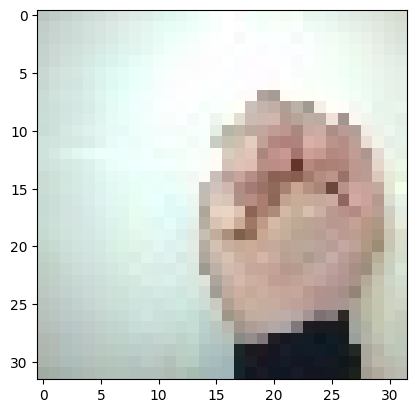

In [47]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
# train_test_split is a scikit-learn's function which helps us to split train and test images kept in the same folders
(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.25, random_state=42)


# convert the labels from integers to vectors 
# perform One hot encoding of all the labels using scikit-learn's function LabelBinarizer
# LabelBinarizer fit_transform finds all the labels 
lb = preprocessing.LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

#trainX = trainX.reshape(trainX.shape[0], 32, 32, 3)
#testX = testX.reshape(testX.shape[0], 32, 32, 3)


print(np.shape(trainX))
print(np.shape(trainY))
print(np.shape(testX))
print(np.shape(testY))

randomint = np.random.randint(low = 1, high = 120)
img = (trainX[randomint, : ,: ,:])


pyplot.imshow(img)



In [48]:

model = keras.Sequential()


model.add(qconvolutional.QConv2D(
    25, (3, 3), strides=(1,1),
    kernel_quantizer=quantized_bits(7,1),
    bias_quantizer=quantized_bits(7,1),
    name="conv2d1", input_shape = (32,32,3)))

model.add(QActivation(activation=quantized_relu(7), name='relu1'))

model.add(layers.MaxPool2D(pool_size=(1,1)))

model.add(qconvolutional.QConv2D(
    5, (3, 3), strides=(1,1),
    kernel_quantizer=quantized_bits(7,1),
    bias_quantizer=quantized_bits(7,1),
    name="conv2d2"))

model.add(QActivation(activation=quantized_relu(7), name='relu2'))

model.add(layers.MaxPool2D(pool_size=(1,1)))

model.add(layers.Flatten())

model.add(
    QDense(
        5,
        name='fc1',
        kernel_quantizer=quantized_bits(7, 1, alpha=1),
        bias_quantizer=quantized_bits(7, 1, alpha=1),
    ))
model.add(QActivation(activation=quantized_relu(7), name='relu3'))


model.add(
    QDense(
        3,
        name='fc2',
        kernel_quantizer=quantized_bits(7, 1, alpha=1),
        bias_quantizer=quantized_bits(7, 1, alpha=1),
    ))
model.add(layers.Activation(activations.softmax))


In [49]:

from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning, PruningSummaries

pruning_params = {

    "pruning_schedule": pruning_schedule.PolynomialDecay(
    initial_sparsity = 0,
    final_sparsity = .90,
    begin_step = 100,
    end_step = 3000,
    power=1.5,
    frequency=100)
    

    }
model = prune.prune_low_magnitude(model, **pruning_params)


In [50]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d1  (None, 30, 30, 25)       1377      
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_relu1 (  (None, 30, 30, 25)       1         
 PruneLowMagnitude)                                              
                                                                 
 prune_low_magnitude_max_poo  (None, 30, 30, 25)       1         
 ling2d_6 (PruneLowMagnitude                                     
 )                                                               
                                                                 
 prune_low_magnitude_conv2d2  (None, 28, 28, 5)        2257      
  (PruneLowMagnitude)                                            
                                                      

In [51]:

optimizer=tf.keras.optimizers.Adam()
optimizer.learning_rate.assign(0.0005)

call = []
call.append(pruning_callbacks.UpdatePruningStep())
call.append(tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.05,
    patience=5,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=400,
))

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy']
             )


In [52]:
# training the model
model.fit(trainX, trainY, batch_size=10, epochs=600 ,callbacks=call, validation_data=(testX, testY))
model = strip_pruning(model)

Epoch 1/600
9/9 [==============================] - 8s 180ms/step - loss: 1.1062 - accuracy: 0.3111 - val_loss: 1.1024 - val_accuracy: 0.3333
Epoch 2/600
9/9 [==============================] - 0s 20ms/step - loss: 1.0951 - accuracy: 0.3111 - val_loss: 1.0973 - val_accuracy: 0.3333
Epoch 3/600
9/9 [==============================] - 0s 19ms/step - loss: 1.0897 - accuracy: 0.3667 - val_loss: 1.0906 - val_accuracy: 0.3667
Epoch 4/600
9/9 [==============================] - 0s 20ms/step - loss: 1.0725 - accuracy: 0.4111 - val_loss: 1.0922 - val_accuracy: 0.2333
Epoch 5/600
9/9 [==============================] - 0s 20ms/step - loss: 1.0434 - accuracy: 0.5667 - val_loss: 1.0997 - val_accuracy: 0.3000
Epoch 6/600
9/9 [==============================] - 0s 21ms/step - loss: 1.0098 - accuracy: 0.6111 - val_loss: 1.0932 - val_accuracy: 0.2333
Epoch 7/600
9/9 [==============================] - 0s 20ms/step - loss: 0.9395 - accuracy: 0.6000 - val_loss: 1.0729 - val_accuracy: 0.2667
Epoch 8/600
9/9 [==

% of zeros = 0.8992592592592593


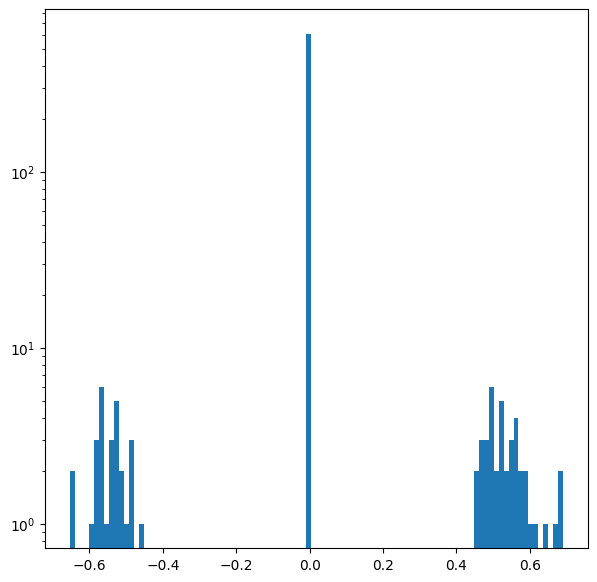

In [53]:
w = model.layers[0].weights[0].numpy()
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7, 7))
plt.bar(b[:-1], h, width=b[1] - b[0])
plt.semilogy()
print('% of zeros = {}'.format(np.sum(w == 0) / np.size(w)))

In [54]:
model.save("my_model.keras")

1/1 [==============================] - 1s 1s/step
Accuracy: 0.5333333333333333


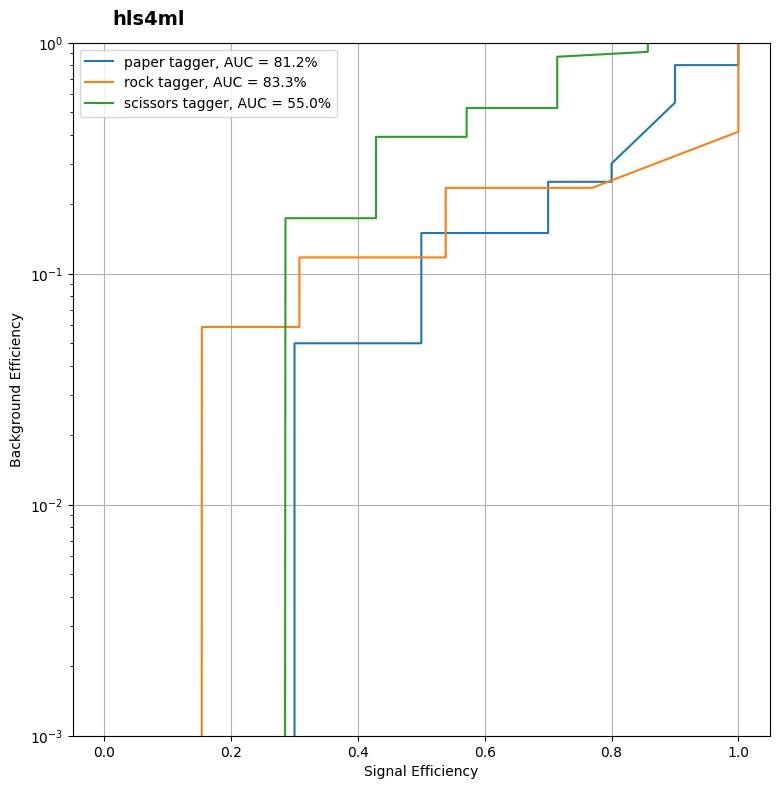

In [55]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

y_predict = model.predict(testX)
print("Accuracy: {}".format(accuracy_score(np.argmax(testY, axis=1), np.argmax(y_predict, axis=1))))
plt.figure(figsize=(9, 9))
_ = plotting.makeRoc(testY, y_predict, lb.classes_)

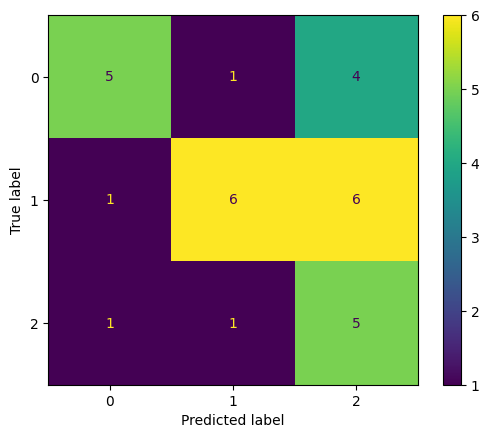

In [56]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix1 = metrics.confusion_matrix(np.argmax(testY, axis=1), np.argmax(y_predict, axis=1))

cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix1)

cm_display1.plot()
plt.show()



3/3 [==============================] - 0s 13ms/step


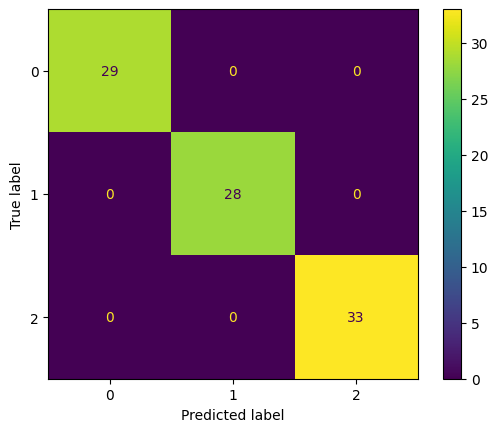

In [57]:
trainp = model.predict(trainX)


confusion_matrix2 = metrics.confusion_matrix(np.argmax(trainY, axis=1), np.argmax(trainp, axis=1))

cm_display2 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix2)

cm_display2.plot()
plt.show()
